# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj probowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

--2021-01-22 16:48:08--  https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.128.133, 151.101.64.133, 151.101.0.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.128.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233926 (228K) [image/png]
Saving to: 'dom.png'

     0K .......... .......... .......... .......... .......... 21% 1,48M 0s
    50K .......... .......... .......... .......... .......... 43% 5,48M 0s
   100K .......... .......... .......... .......... .......... 65% 1,94M 0s
   150K .......... .......... .......... .......... .......... 87% 7,25M 0s
   200K .......... .......... ........                        100% 7,42M=0,08s

2021-01-22 16:48:09 (2,87 MB/s) - 'dom.png' saved [233926/233926]



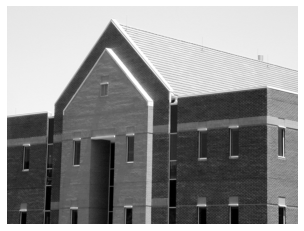

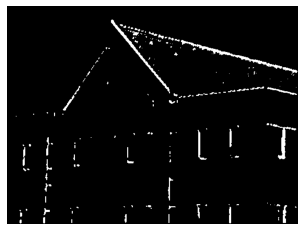

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

if not os.path.exists("dom.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png --no-check-certificate

I_dom = cv2.imread("dom.png", cv2.IMREAD_GRAYSCALE)

plt.imshow(I_dom, 'gray')
plt.axis('off')
plt.show()
# I_dom.shape = (417, 557)

kSize = (3,3)
sigma = 0
ddepth = cv2.CV_32F
I_dom_gauss = cv2.GaussianBlur(I_dom, kSize, sigma) # rozmycie Gaussowskie obrazu wejściowego
I_dom_LoG = cv2.Laplacian(I_dom_gauss, ddepth) # laplasjan obrazu rozmytego

def crossing(LoG, thr): # funkcja wyznaczająca miajsca zmiany znaku
    macierz = np.zeros(LoG.shape) # tablica do której zostanie zapisany wynik
    for i in range (1,LoG.shape[0]-1):
        for j in range (1,LoG.shape[1]-1):
            otoczenie = LoG[i-1:i+2, j-1:j+2]
            max = np.amax(otoczenie)
            min = np.amin(otoczenie)
            if max * min < 0:
                if LoG[i,j] > 0: macierz[i,j] = LoG[i,j] + abs(min)
                else: macierz[i,j] = abs(LoG[i,j]) + max
    macierz = macierz / macierz.max() * 255.0
    thr_LoG = macierz > thr
    thr_LoG = thr_LoG * 255
    thr_LoG = thr_LoG.astype('uint8')
    blured = cv2.medianBlur(thr_LoG, 3)
    return blured

I_dom_crossed = crossing(I_dom_LoG, 95)
plt.imshow(I_dom_crossed, 'gray')
plt.axis('off')
plt.show()

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w~1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj algorytm detekcji krawędziCanny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Dlatego wykorzystuje się obraz $g_{NL}$ w następującej procedurze:
    - Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
    - Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
    - Stwórz obraz, któy zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
    - Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź (potencjalną).
        Można to wykoanać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować wbardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj algorytm Cannego.

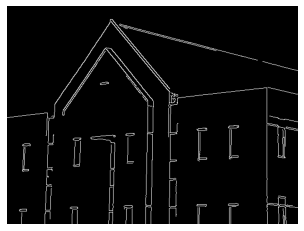

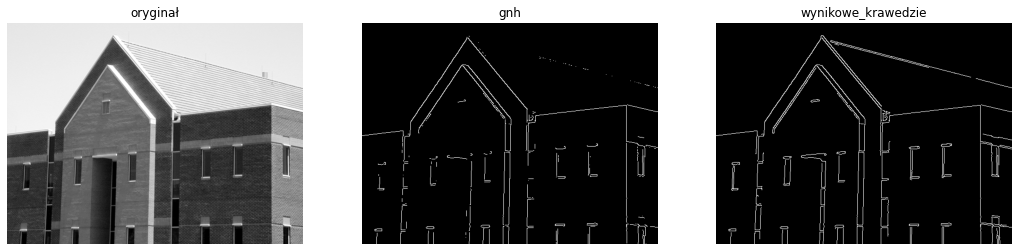

In [2]:
I_dom_gauss = cv2.GaussianBlur(I_dom, (3,3), 1.4) # filtracja dwuwymiarowym filtrem Gaussa
gradient_x = cv2.Sobel(np.float32(I_dom_gauss),cv2.CV_64F,1,0,ksize=3)
gradient_y = cv2.Sobel(np.float32(I_dom_gauss),cv2.CV_64F,0,1,ksize=3)

amplituda = np.sqrt(gradient_x**2 + gradient_y**2)
kat_radiany = np.arctan2(gradient_y, gradient_x)
# amplituda, kat_radiany = cv2.cartToPolar(gradient_x, gradient_y)

kat_stopnie = np.rad2deg(kat_radiany)

dang = np.zeros(I_dom.shape)
amplituda_kopia = amplituda.copy()
for i in range(I_dom.shape[0]):
    for j in range (I_dom.shape[1]):
        grad_ang = kat_stopnie[i, j]
        if 22.5 >= grad_ang >= -22.5 or grad_ang <= -157.5 or grad_ang >= 157.5:
            dang[i,j] = 1
            neighb_1 = i, j-1
            neighb_2 = i, j+1
        elif 67.5 >= grad_ang >= 22.5 or -112.5 >= grad_ang >= -157.5:
            dang[i,j] = 2
            neighb_1 = i - 1, j - 1
            neighb_2 = i + 1, j + 1
        elif 112.5 >= grad_ang >= 67.5 or -67.5 >= grad_ang >= -112.5:
            dang[i,j] = 3
            neighb_1 = i-1, j
            neighb_2 = i+1, j
        elif 157.5 >= grad_ang >= 112.5 or -22.5 >= grad_ang >= -67.5:
            dang[i,j] = 4
            neighb_1 = i + 1, j - 1
            neighb_2 = i - 1, j + 1

        if I_dom.shape[0]>neighb_1[0]>=0 and I_dom.shape[1]>neighb_1[1]>=0:
            if amplituda[i, j] < amplituda[neighb_1[0], neighb_1[1]]:
                amplituda_kopia[i, j]= 0
                continue
        if I_dom.shape[0]>neighb_2[0]>=0 and I_dom.shape[1]>neighb_2[1]>=0:
            if amplituda[i, j] < amplituda[neighb_2[0], neighb_2[1]]:
                amplituda_kopia[i, j]= 0

tl=100
th=200
gnh = amplituda_kopia >= th # pewnie krawędzie
gnl = np.zeros(I_dom.shape, dtype=bool) #potencjalne krawędzie

for i in range(I_dom.shape[0]):
    for j in range (I_dom.shape[1]):
        if th >= amplituda_kopia[i,j] >= tl:
            gnl[i,j] = True
        else:
            gnl[i,j] = False
lista = []
for i in range(I_dom.shape[0]):
    for j in range (I_dom.shape[1]):
        if gnh[i,j]: lista.append([i,j])
czy_odwiedzony = np.full(I_dom.shape, False, dtype=bool)
wynikowe_krawedzie = np.zeros(I_dom.shape)

while len(lista)!=0:
    element_ze_stosu = lista.pop()
    if not czy_odwiedzony[element_ze_stosu[0], element_ze_stosu[1]]:
        czy_odwiedzony[element_ze_stosu[0], element_ze_stosu[1]] = True
        wynikowe_krawedzie[element_ze_stosu[0], element_ze_stosu[1]] = 1
        for i in range(element_ze_stosu[0]-1,element_ze_stosu[0]+2):
            for j in range (element_ze_stosu[1]-1,element_ze_stosu[1]+2):
                if I_dom.shape[0]>i>=0 and I_dom.shape[1]>j>=0:
                    if gnl[i,j]: lista.append([i,j])

plt.imshow(wynikowe_krawedzie, 'gray')
plt.axis('off')

plt.show()

f, p = plt.subplots(1, 3, figsize=(18,9))
p[0].imshow(I_dom, 'gray')
p[0].set_title("oryginał")
p[0].axis('off')
p[1].imshow(gnh, 'gray')
p[1].set_title("gnh")
p[1].axis('off')
p[2].imshow(wynikowe_krawedzie, 'gray')
p[2].set_title("wynikowe_krawedzie")
p[2].axis('off')
plt.show()

## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z własną implementacją.

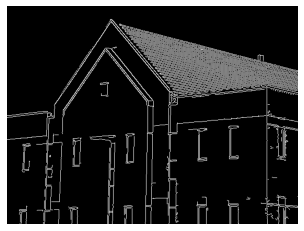

In [3]:
I_dom_canny = cv2.Canny(I_dom, tl, th, None, 3, 1)
plt.imshow(I_dom_canny, 'gray')
plt.axis('off')
plt.show()
